# どのくらいのトピックに分類するのが程よいか調べる

In [4]:
from tqdm import tqdm
import gensim
from gensim import corpora
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel
import pandas as pd
import numpy as np

# 対象データを読み込む
df = pd.read_csv('tokenized/merge_tokenized.csv')

# 訓練データの整形
texts = []
sentenses = df['tokens'].values
for row in sentenses:
    texts.append(row.strip().split(' '))

# データからコーパスを取得
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

start = 2
limit = 22
step = 1

coherence_vals = []
perplexity_vals = []

for n_topic in tqdm(range(start, limit, step)):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=n_topic, random_state=0)
    perplexity_vals.append(np.exp2(-lda_model.log_perplexity(corpus)))
    coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_vals.append(coherence_model_lda.get_coherence())



  0%|          | 0/20 [00:00<?, ?it/s]

  5%|▌         | 1/20 [00:39<12:35, 39.77s/it]

 10%|█         | 2/20 [01:17<11:43, 39.09s/it]

 15%|█▌        | 3/20 [01:55<10:58, 38.74s/it]

 20%|██        | 4/20 [02:33<10:19, 38.71s/it]

 25%|██▌       | 5/20 [03:11<09:36, 38.44s/it]

 30%|███       | 6/20 [03:49<08:56, 38.29s/it]

 35%|███▌      | 7/20 [04:27<08:15, 38.14s/it]

 40%|████      | 8/20 [05:04<07:35, 37.94s/it]

 45%|████▌     | 9/20 [05:42<06:57, 37.99s/it]

 50%|█████     | 10/20 [06:22<06:23, 38.31s/it]

 55%|█████▌    | 11/20 [07:00<05:45, 38.37s/it]

 60%|██████    | 12/20 [07:40<05:10, 38.86s/it]

 65%|██████▌   | 13/20 [08:20<04:34, 39.27s/it]

 70%|███████   | 14/20 [09:01<03:58, 39.71s/it]

 75%|███████▌  | 15/20 [09:41<03:19, 39.93s/it]

 80%|████████  | 16/20 [10:24<02:42, 40.58s/it]

 85%|████████▌ | 17/20 [11:05<02:02, 40.95s/it]

 90%|█████████ | 18/20 [11:47<01:22, 41.27s/it]

 95%|█████████▌| 19/20 [12:30<00:41, 41.64s/it]

100%|██████████| 20/20 [13:13<00:00,

# 学習した結果を図示する。
トピック数毎の制度や品質を評価する。どの程度のトピック数に分類するのが良さそうか判断する参考となる。
評価項目は下記の通りであり、これらの両方の数値が良好なトピック数が適していると考えられる。

* coherence : トピックの品質を測る評価指標、高い方が良い。
* perplexity : モデルの予測精度の評価指標、低い方が良い。

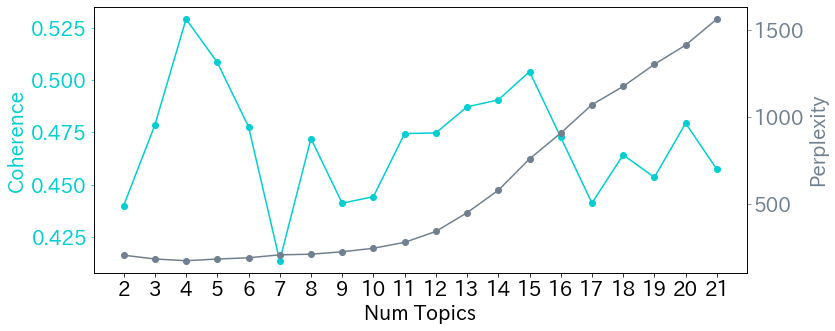

In [6]:
# pyLDAvis
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt

pyLDAvis.enable_notebook()

plt.rcParams['font.family'] = 'IPAexGothic'
plt.rcParams["font.size"] = 20

x = range(start, limit, step)

fig, ax1 = plt.subplots(figsize=(12,5))

# coherence
c1 = 'darkturquoise'
ax1.plot(x, coherence_vals, 'o-', color=c1)
ax1.set_xlabel('Num Topics')
ax1.set_ylabel('Coherence', color=c1); ax1.tick_params('y', colors=c1)

# perplexity
c2 = 'slategray'
ax2 = ax1.twinx()
ax2.plot(x, perplexity_vals, 'o-', color=c2)
ax2.set_ylabel('Perplexity', color=c2); ax2.tick_params('y', colors=c2)

# Vis
ax1.set_xticks(x)
fig.tight_layout()
plt.show()

# LDAトピックモデルの作成
上記で評価して良さそうなトピックス数で分類してみる。
4が程よいと考えられる。

In [9]:
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel
from collections import defaultdict
from sklearn.model_selection import train_test_split
import pandas as pd

# 分類するトピック数を設定する。上記の分類で4が程良さそうであるため4とする。
NUM_TOPICS = 4

# カテゴリ数を取得する。
df = pd.read_csv('tokenized/merge_tokenized.csv')

# 訓練データの整形
texts = []
sentenses = df['tokens'].values
for row in sentenses:
    texts.append(row.strip().split(' '))

# データからモデル作成
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]
lda_model = LdaModel(corpus=corpus, num_topics=NUM_TOPICS, id2word=dictionary)

# LDAトピックモデルのWordCloud
生成されたトピックについて、代表的な単語を可視化する。各トピックがどのような内容で分類されているのかは、分析者がトピックの内容から判断する。

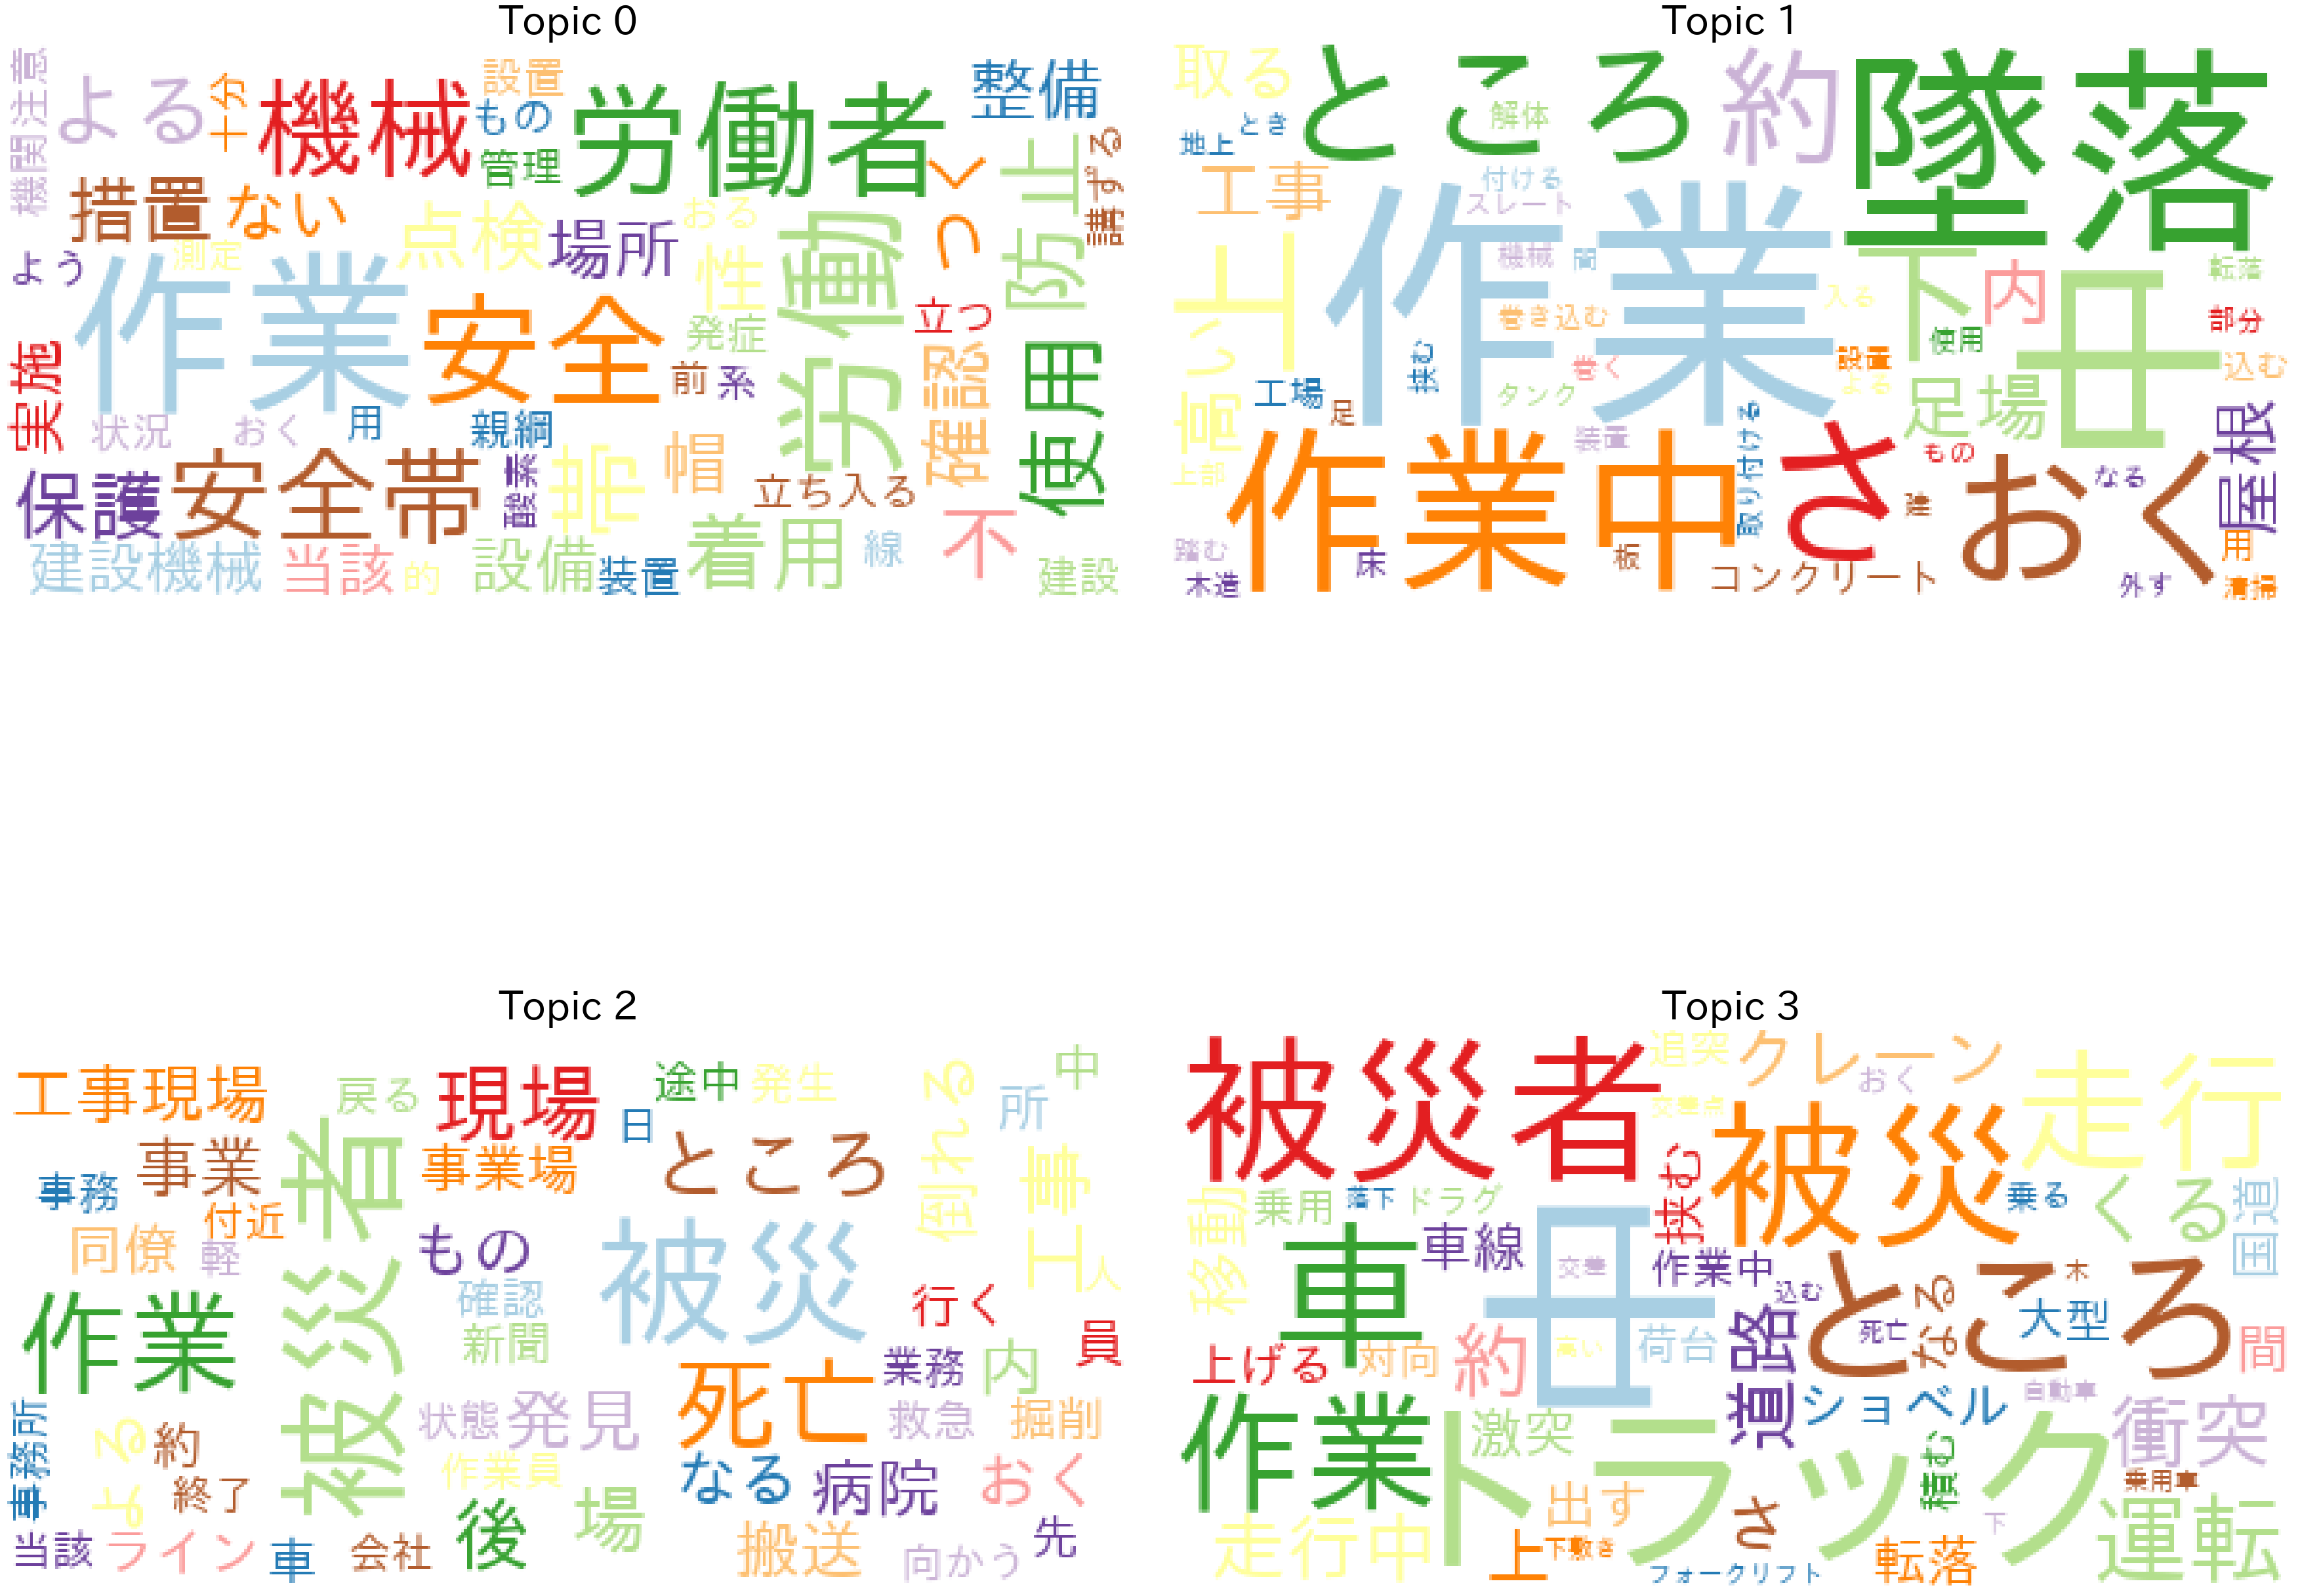

In [12]:
from wordcloud import WordCloud
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'IPAexGothic'
plt.rcParams["font.size"] = 50

fig, axs = plt.subplots(ncols=2, nrows=int(lda_model.num_topics/2), figsize=(50,50))
axs = axs.flatten()

def color_func(word, font_size, position, orientation, random_state, font_path):
    return 'darkturquoise'

for i, t in enumerate(range(lda_model.num_topics)):

    x = dict(lda_model.show_topic(t, 50))
    im = WordCloud(
        font_path='/usr/share/fonts/truetype/ipaexg.ttf',
        background_color='white',
        color_func=color_func,
        random_state=0
    ).generate_from_frequencies(x)
    axs[i].imshow(im.recolor(colormap= 'Paired_r' , random_state=244), alpha=0.98)
    axs[i].axis('off')
    axs[i].set_title('Topic '+str(t))
        
plt.tight_layout()
plt.show()

# トピック間の距離や、トピックを表す代表的な単語を可視化する。

In [16]:
import warnings
warnings.filterwarnings('ignore')

# Vis PCoA
# lda_model = LdaModel(corpus=corpus, num_topics=4, id2word=dictionary)
vis_pcoa = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary, sort_topics=False)
vis_pcoa

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.180896 -0.016680       1        1  43.894012
1      0.295386 -0.119327       2        1  15.358975
2     -0.156985 -0.132596       3        1  25.005733
3      0.042496  0.268603       4        1  15.741272, topic_info=    Category          Freq Term         Total  loglift  logprob
378  Default  13706.000000   労働  13706.000000  30.0000  30.0000
12   Default  55700.000000   作業  55700.000000  29.0000  29.0000
379  Default  11218.000000  労働者  11218.000000  28.0000  28.0000
428  Default  14805.000000    車  14805.000000  27.0000  27.0000
160  Default   5997.000000   機械   5997.000000  26.0000  26.0000
..       ...           ...  ...           ...      ...      ...
82    Topic4   2308.140137   よる  11980.271484   0.2021  -4.9450
30    Topic4   2020.995728   込む   6849.366211   0.6283  -5.0779
153   Topic4   2383.039551    中  33492.812500  -0.7941  -4.9131
154   Topic4   1924.575439  作業中  11642.676758   0.0489  -5.1267
8     Topic4   1877.293335   おく  14886.700195  -0.2218  -5.1516

[323 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
590       1  0.990821    3m
590       2  0.000494    3m
590       3  0.008393    3m
8         1  0.612292    おく
8         2  0.139185    おく
...     ...       ...   ...
2127      1  0.998413    高速
2127      2  0.000461    高速
2127      4  0.000922    高速
2128      1  0.998886  高速道路
2128      2  0.000586  高速道路

[826 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4])